## Geoinformatics Center, AIT
## Training of Application of Remote Sensing in Cryosphere Monitoring

#### Practical 1: Snow Covered Area Calculation uisng NDSI Thresholding Method

#### Content prepared by Swun Wunna Htet
#### Date: 17th Jan 2024.




Step 1: install GEE python API in the colab environment

In [ ]:
# ! pip install geemap

# ! pip install pycrs
! pip install geetools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for geetools: filename=geetools-0.6.14-py3-none-any.whl size=92089 sha256=201cf25318c9d2833c65e067513b253c0b6628187be5ee9fab905f98afcef451
  Stored in directory: /root/.cache/pip/wheels/e9/a8/7f/40bf5aafcc334b20cd12d0328aff7861e8ea655c20190967fb
Successfully built geetools


Step 2: import python libraries to utilize

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import ee
import geemap
import geetools

Step 3: Authenticate and initialize earthe engine. If you have a specific GEE projects specify that project

In [ ]:
ee.Authenticate()
ee.Initialize(project = 'ee-swunait')

Connecting with your google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# date filter of image collection
start = ee.Date('2020-01-01')
end = ee.Date('2020-12-31')

We will upload our shapefile of area of interest into your GEE project assets.

In case you have error message (No module names pycrs), run this code in an new cell;
! pip install pycrs

In [ ]:
aoi = geemap.shp_to_ee(r'/content/drive/MyDrive/cryosphere_monitoring/filtered_tibet_watershed.shp')

In [ ]:
# Let's see our metadata of aoi. AOI is now termed as Feature Collection.
display(aoi)

We will filter our Landsat 8 image collection with date and only within area of interest for a few selected band.

In [ ]:
band = ['SR_B3', 'SR_B6', 'QA_PIXEL']
# importing the L8 imagecollection specific within the date range
l8 = ee.ImageCollection("LANDSAT/LC08/C02/T2_L2").filterDate(start, end).filterBounds(aoi).select(band)

Let's check out the metadata of L8 collection

In [ ]:
# Let's see what kind of metadata L8 single ee.image has to offer
display(l8.limit(10))
display(l8.size())

Notice that our L8 is not converted from digital number (DN) to surface reflectance. The conversion formula is:

SR = (MULT * DN) + ADD

Where:  MULT = multiplicative factor of corresponding band
        ADD = additive factor of corresponding band
        DN  = image digital number

After adjustment, we will do quality masking to our image.

In [ ]:
# starts with function which returns ee.Number and return
def DNtoSR(img):
  # for band 3 (Green)
  add3 = ee.Number(img.get('REFLECTANCE_ADD_BAND_3'))
  dn3 = img.select('SR_B3')
  mul3 = ee.Number(img.get('REFLECTANCE_MULT_BAND_3'))

  sr3 = (dn3.multiply(mul3)).add(add3)

  # for band 6 (SWIR)
  add6 = ee.Number(img.get('REFLECTANCE_ADD_BAND_6'))
  dn6 = img.select('SR_B6')
  mul6 = ee.Number(img.get('REFLECTANCE_MULT_BAND_6'))

  sr6 = (dn6.multiply(mul6)).add(add6)

  return sr3.addBands([sr6, img.select(band[2])]).copyProperties(img, ['system:time_start']);


In [ ]:
adj_l8 = l8.map(DNtoSR)

display(adj_l8.limit(10))

Quality masking/Clipping starts here

In [ ]:
def qltymsk(img):

  cloudbit = 1 << 3
  cloudshadowbit = 1 << 4

  qa = img.select(band[2])

  cloudmask =ee.Image((qa.bitwiseAnd(cloudbit)).eq(0))
  cloudshadowmask = ee.Image(qa.bitwiseAnd(cloudshadowbit).eq(0))

  mask = cloudmask.And(cloudshadowmask)
  image = (img.updateMask(mask).select(band[:2])).clip(aoi)

  return ee.Image(image).copyProperties(img, ['system:time_start'])

In [ ]:
adj_msk_l8 = adj_l8.map(qltymsk)

display(adj_msk_l8.limit(10))

Now, we will calculate NDSI with the preproceseed image collection

In [ ]:
# function to calculate NDSI
def ndsicalc(img):

  ndsi = img.normalizedDifference([band[0], band[1]]).rename('ndsi')
  return ndsi.copyProperties(img, ['system:time_start'])

In [ ]:
ndsi_col = adj_msk_l8.map(ndsicalc)

display(ndsi_col.limit(10))

Mosaicing images of the same date

In [ ]:
def mergebyDate(imcol):

  # from image collection to a list
  imglist = imcol.toList(imcol.size())

  # driver function
  def uniquedate(img):
    return ee.Image(img).date().format('YYYY-MM-dd');

  # applying driver function
  uniquedates = imglist.map(uniquedate).distinct()

  # driver function for mapping the mosaics based on unique dates
  def mosaicDriver(dateid):
    id = ee.Date(dateid)

    image = (imcol.filterDate(id, id.advance(1, 'day'))).mosaic()
    return image.set(
        {'system:time_start': id.millis(),
        'system:id': id.format('YYYY-MM-dd')});

  mosaicImglist = uniquedates.map(mosaicDriver)

  return ee.ImageCollection(mosaicImglist)

In [ ]:
ndsimosaic = mergebyDate(ndsi_col)

# display(ndsimosaic.limit(5))

In [ ]:
meanndsi = ndsimosaic.mean()

display(meanndsi)

Let's visualize the overall ndsi condition of a selected area of interest

In [ ]:
# we will create a map layout
basemap = geemap.Map()

In [ ]:
# adding area of interest and annual mean result in the map

basemap.addLayer(aoi, {'color': 'blue', 'opacity': 0.5}, 'Area of Interest')
basemap.addLayer(meanndsi, {'min':-1, 'max':1, 'palette':['red', 'green', 'blue']}, 'Annual mean NDSI')

In [ ]:
basemap

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

Let's go visualization with time series pattern of NDSI

In [ ]:
def extractNDSItime(img):
  ndsi = img.select('ndsi')

  mean = ndsi.reduceRegion(reducer = ee.Reducer.mean(),
                           geometry = aoi,
                           bestEffort = True)
  val = mean.get('ndsi')

  return img.set('DateDict', img.date().format()).set('ndsi', val)

In [ ]:
ndsi_timeseries = ndsimosaic.map(extractNDSItime)

We will use from two list in imagecollection into pandas dataframe

In [ ]:
nested_list = ndsi_timeseries.reduceColumns(ee.Reducer.toList(2), ['DateDict', 'ndsi']).values().get(0)

We will get the nested list into pandas dataframe, and small formatting to workable excel sheet

In [ ]:
df =pd.DataFrame(nested_list.getInfo(), columns=['DateDict', 'ndsi'])
df['DateDict'] = pd.to_datetime(df['DateDict'])
df = df.set_index('DateDict')


Plotting the time series of NDSI for 2020.

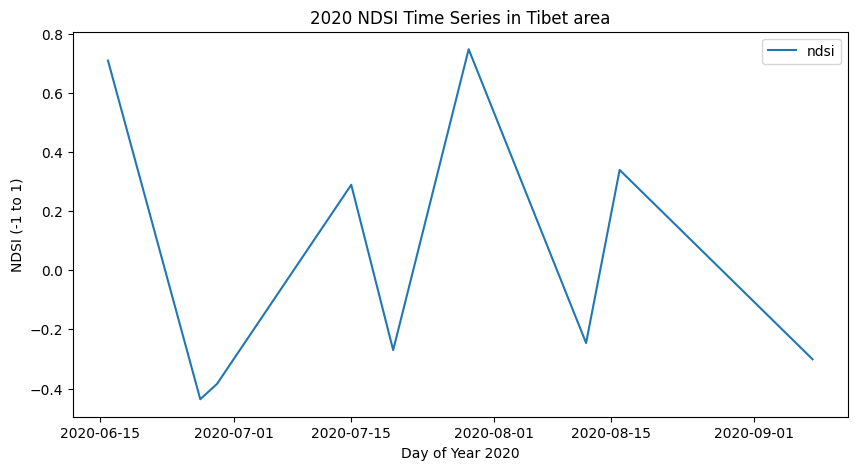

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))

sns.lineplot(data = df, ax = ax)

ax.set_ylabel('NDSI (-1 to 1)', fontsize = 10)
ax.set_xlabel('Day of Year 2020', fontsize = 10)
ax.set_title('2020 NDSI Time Series in Tibet area', fontsize = 12)

plt.show()

Saving the NDSI Time Series as Excel Sheets

In [ ]:
writer = pd.ExcelWriter('/content/drive/MyDrive/cryosphere_monitoring/NDSI_timeseries_2020.xlsx', engine = 'openpyxl')

df.to_excel(writer, sheet_name = 'NDSI')
writer.close()

From this exercise, you now understand how you interpret NDSI and and its probable snow existance can be established as time series.

Snow practitioners would like to evaluate the snow convered area (SCA) and its variability in a given area. So, we will familiarize about it.

---
## Time-Series Snow Convered Area Calculation

---
The calculation of SCA in remote sensing can be known as:

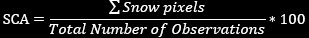


The first thing is to reclassify NDSI and binary snow covers (1 = snow, 0 = no snow) using thresholding method.

Generally, NDSI >= 0.4 is a good representation of snow in a lot of experiments. (Riggs et.al (2016))

In [ ]:
# creating the reclassification of snow convered area function
ndsi_list = ndsimosaic.toList(ndsimosaic.size(),0)

def calculateSCA(i):
  # item is ee.Image from ee.List
  img = ee.Image(ndsi_list.get(i))

  # get pixel area from current projection
  pixelarea = ee.Image.pixelArea()

  limit = 0.4 # this threshold will decide snow/no snow condition

  scale = 500 # at which scale level, you want to reduce down statistics

  sc_bin = img.select('ndsi').gte(ee.Image.constant(limit))

  sc_img = sc_bin.multiply(pixelarea).rename('SCA')



  sca_dict = sc_img.reduceRegion(reducer= ee.Reducer.sum(),geometry =aoi,
      scale= scale, crs='EPSG:4326'
  )

  # extract value from ee.Dictionary
  sca = sca_dict.getNumber('SCA')
  return sca;


sca_list = ee.List.sequence(0,ndsi_list.length().subtract(1)).map(calculateSCA)

In [ ]:
display(sca_list)

In [ ]:
# Date list creation
def date_return(i):
  img = ee.Image(ndsi_list.get(i))
  date = img.date().format('YYYY-MM-dd')
  return date;

datelist = ee.List.sequence(0, ndsi_list.length().subtract(1)).map(date_return)

In [ ]:
display(datelist)

In [ ]:
df2 = pd.DataFrame({'Date': datelist.getInfo(),
                    'SCA (m2)': sca_list.getInfo()},
                    columns = ['Date', 'SCA (m2)'])
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.set_index('Date')

In [ ]:
df2

,SCA (m2)
Date,
2020-07-15,2.684280e+08
2020-07-31,2.964358e+07
2020-01-21,2.251464e+08
2020-05-12,5.841193e+08
2020-06-13,3.855856e+08
2020-06-29,8.114460e+07
2020-08-16,8.330712e+06
2020-09-17,0.000000e+00
2020-10-03,1.607658e+08


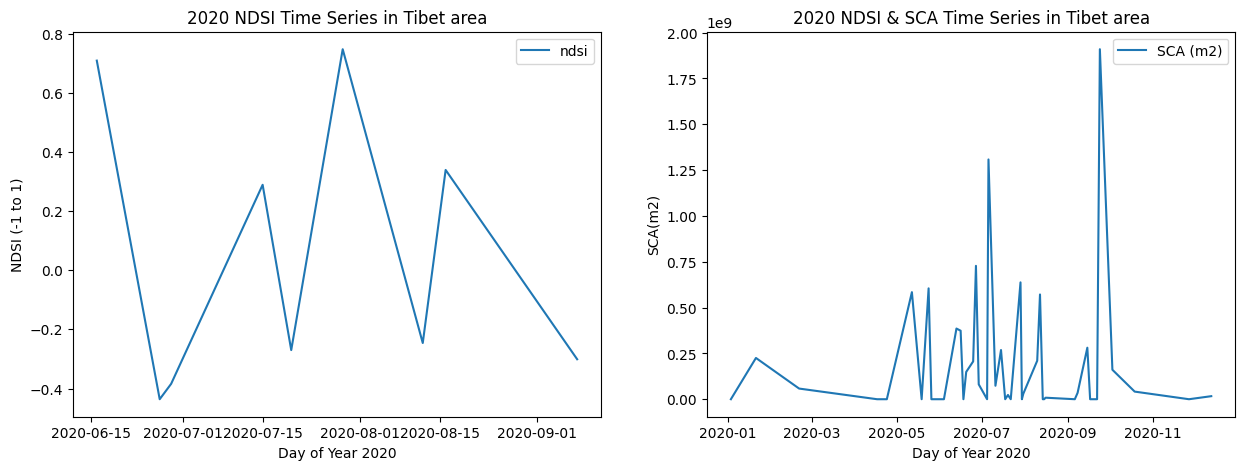

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 5))

sns.lineplot(data = df, ax = ax[0])
sns.lineplot(data = df2, ax = ax[1])

ax[0].set_ylabel('NDSI (-1 to 1)', fontsize = 10)
ax[0].set_xlabel('Day of Year 2020', fontsize = 10)
ax[0].set_title('2020 NDSI Time Series in Tibet area', fontsize = 12)

ax[1].set_ylabel('SCA(m2)', fontsize = 10)
ax[1].set_xlabel('Day of Year 2020', fontsize = 10)
ax[1].set_title('2020 SCA Time Series in Tibet area', fontsize = 12)

plt.title('2020 NDSI & SCA Time Series in Tibet area')
plt.show()

In [ ]:
# exporting the time series of SCA as excel sheet
writer = pd.ExcelWriter('/content/drive/MyDrive/cryosphere_monitoring/SCA_timeseries_2020.xlsx', engine = 'openpyxl')

df2.to_excel(writer, sheet_name = 'SCA')
writer.close()

Exporting NDSI images

In [ ]:
tasks = geetools.batch.Export.imagecollection.toDrive(
    collection = ndsimosaic,
    folder = 'cryosphere_monitoring',
    region = aoi.geometry(),
    namePattern = 'SCA_{id}',
    scale = 500
    datePattern = 'YYYYMMdd'
)


---
End of Practical 1: NDSI Detection

---